In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (6,6)

C:\Users\wb8by\AppData\Local\Temp/ipykernel_27532/348062782.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


Load Data

In [3]:
# Subset of Data (1.5GB per set, 10,000 observations)
Xdata = np.load('Xdata_MeansG.npy') # data with the "noise" of the atmosphere
# clean up Xdata if needed
np.nan_to_num(Xdata, copy=False, nan=1)
Xdata[Xdata<1] = 1
Refdata = np.load('Ydata_MeansG.npy') # Reflectance
# clean up Refdata if needed
Refdata[Refdata<0] = 0
# Full Data (43GB per set, 300,000 observations)
#Xdata = np.load('Xdata.npy') # data with the "noise" of the atmosphere
#Ydata = np.load('Ydata.npy') # clean material spectra
wl = np.load('wl.npy')
nObs, nSpec, nBands = Xdata.shape
print("Num Observations: "+str(nObs))
print("Num Spectra per observation: "+str(nSpec))
print("Num Bands: "+str(nBands))
Ydata = Refdata#/Xdata # the gains we want to predict
# remove data for bad/water bands with nans
IdxGood = np.isfinite(Ydata[0,0])
Ydata = Ydata[:,:,IdxGood]
Xdata = Xdata[:,:,IdxGood]
wl = wl[IdxGood]

Num Observations: 100000
Num Spectra per observation: 40
Num Bands: 453


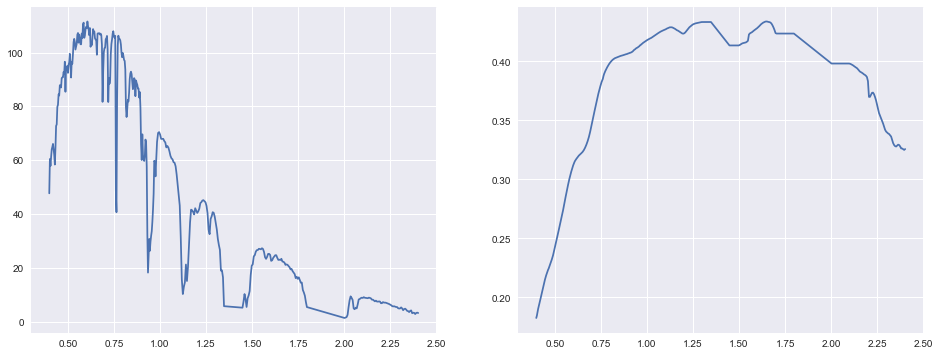

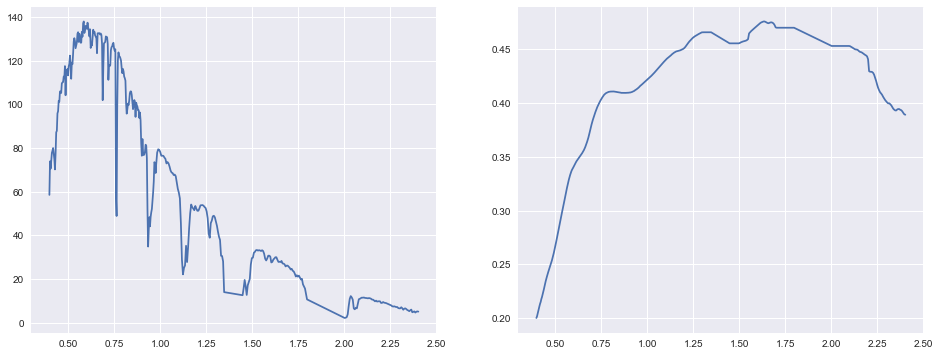

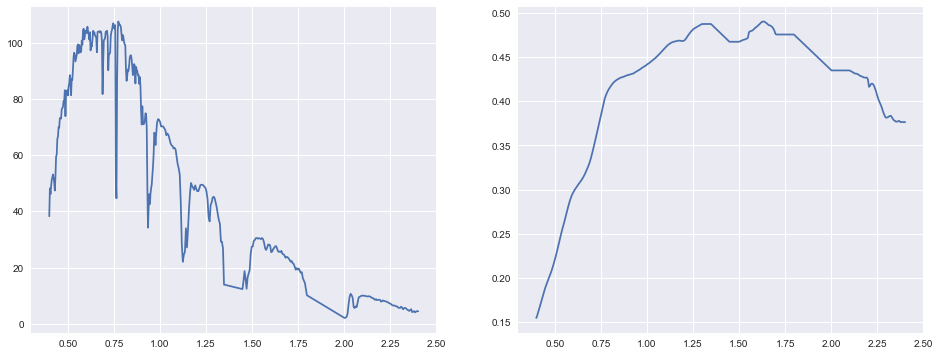

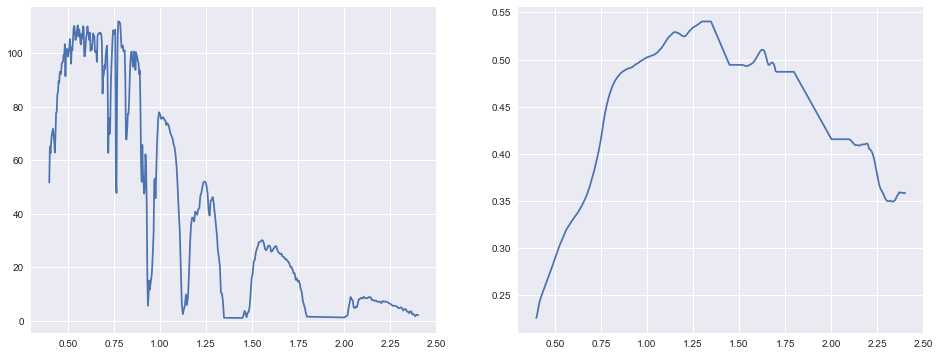

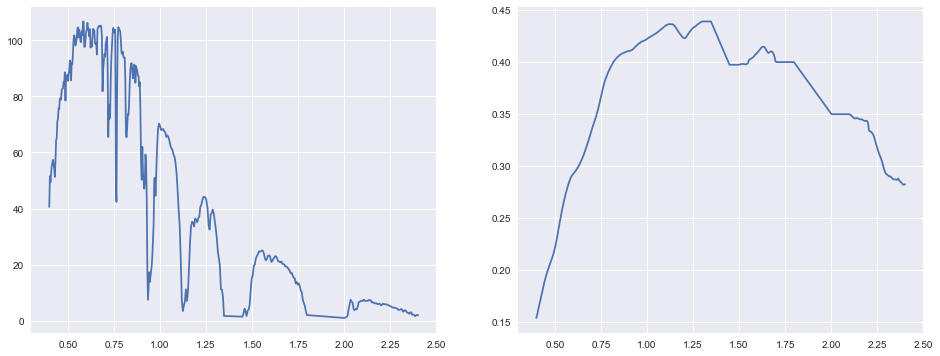

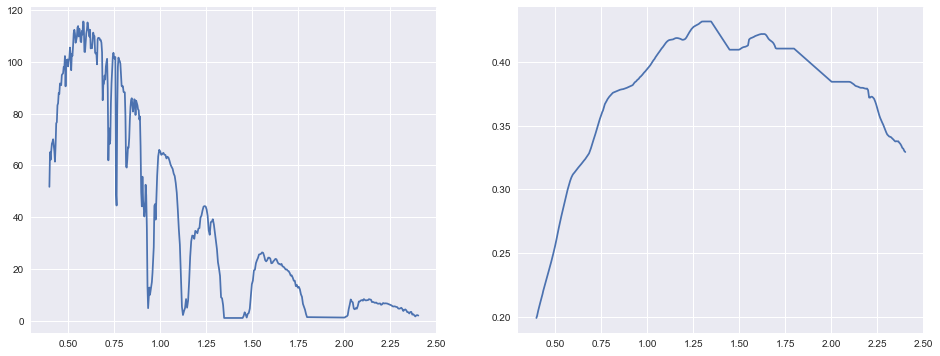

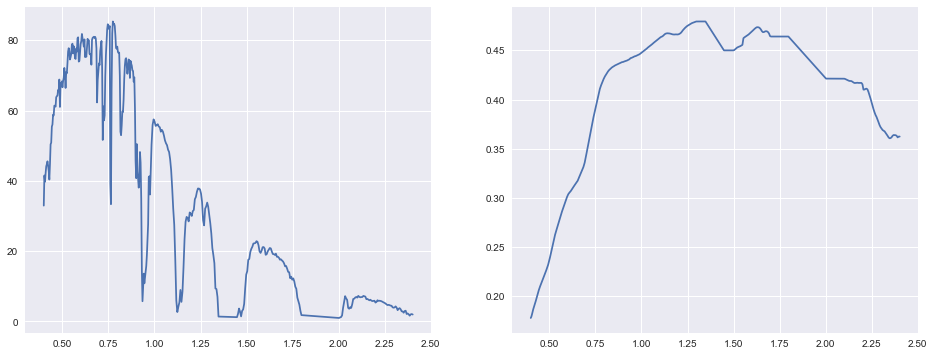

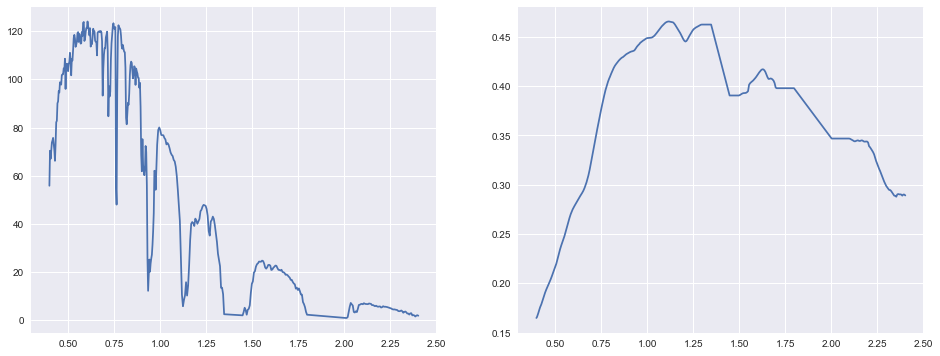

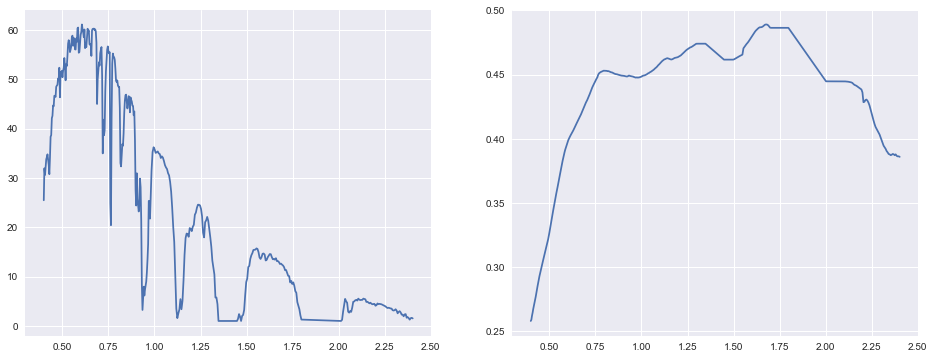

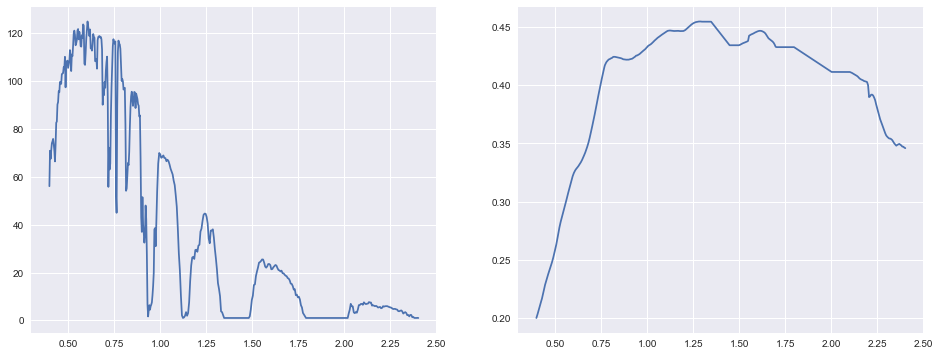

In [4]:
for i in range(10):
  plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(wl,Xdata[i,0,:])
  plt.subplot(122)
  plt.plot(wl,Ydata[i,0,:])

Test / Trin Split

In [4]:
# set aside 1/3 of train and test data for validation
X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata, test_size=0.33, random_state=42)
# Use just the means from the X-data for training and testing, but save the full X-data for future comparison
X_test_full = X_test[:]
X_train = X_train[:,0,:]
X_test = X_test[:,0,:]
Y_test_full = Y_test[:]
Y_train = Y_train[:,0,:]
Y_test = Y_test[:,0,:]
nTrainObs,nBandsY = np.shape(Y_train)
nTestObs,_ = np.shape(Y_test)
print("Bands: "+str(nBandsY))

Bands: 375


Plot some data

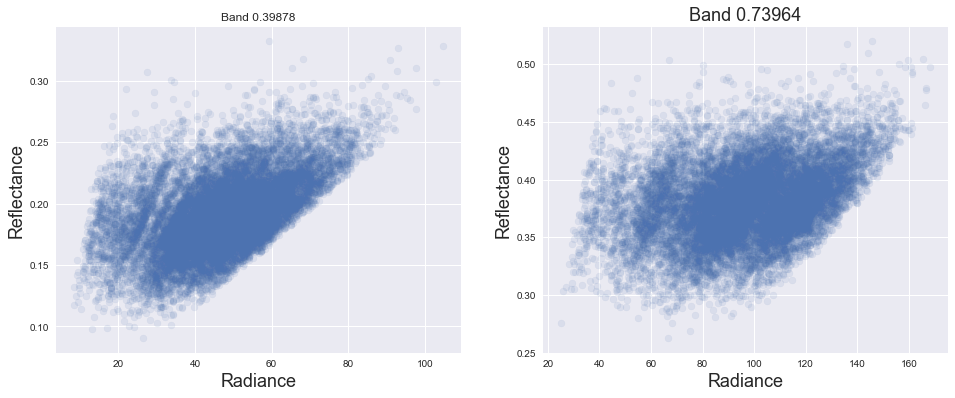

In [5]:
plt.figure(figsize=(16,6))
plt.subplot(121)
nPts = 15000
x = X_train[1:nPts,0]
y = Y_train[1:nPts,0]
plt.scatter(x,y, alpha=0.1)
plt.xlabel('Radiance', fontsize = 18)
plt.ylabel('Reflectance', fontsize = 18)
plt.title('Band '+str(wl[0]))
plt.subplot(122)
nPts = 15000
x = X_train[1:nPts,100]
y = Y_train[1:nPts,100]
plt.scatter(x,y, alpha=0.1)
plt.xlabel('Radiance', fontsize = 18)
plt.ylabel('Reflectance', fontsize = 18)
plt.title('Band '+str(wl[100]), fontsize = 18)
plt.savefig('scatterPlotsRadVsRefl.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [6]:
np.shape(Y_train)

(67000, 375)

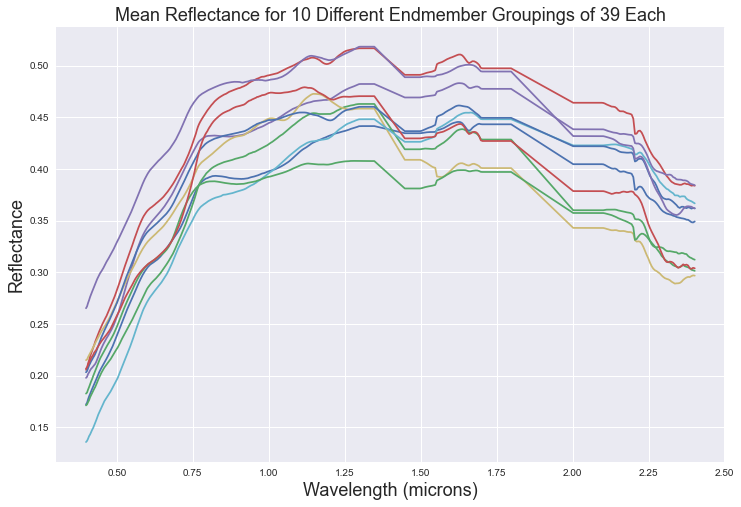

In [7]:
plt.figure(figsize=(12,8))
plt.plot(wl, Y_train[0:10,:].T)
plt.xlabel("Wavelength (microns)", fontsize = 18)
plt.ylabel("Reflectance", fontsize = 18)
plt.title('Mean Reflectance for 10 Different Endmember Groupings of 39 Each', fontsize = 18)
plt.savefig('EndmemberMeans.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [8]:
np.shape(X_train)

(67000, 375)

In [9]:
S_test = np.hstack((X_test,Y_test))
S_train = np.hstack((X_train,Y_train))
nRows, nCols = np.shape(S_train)

In [10]:
# Demean the data
m = np.mean(S_train, 0)
for c in range(nCols):
  S_train[:,c] = S_train[:,c] - m[c]

In [11]:
# Compute the covariance
C = np.zeros((nCols,nCols))
for r in range(0,nRows,2):
  if (r%500==0):
    print(r)
  C = C + np.matmul(S_test[r:(r+1),:].T, S_test[r:(r+1),:]) 
C = C/nRows
print(np.shape(C))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
(750, 750)


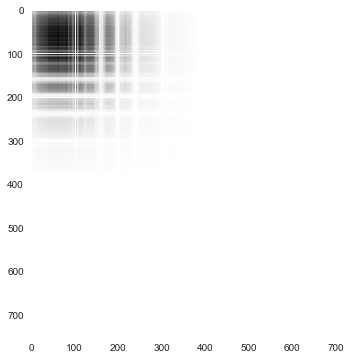

In [12]:
plt.imshow(C)
plt.show()

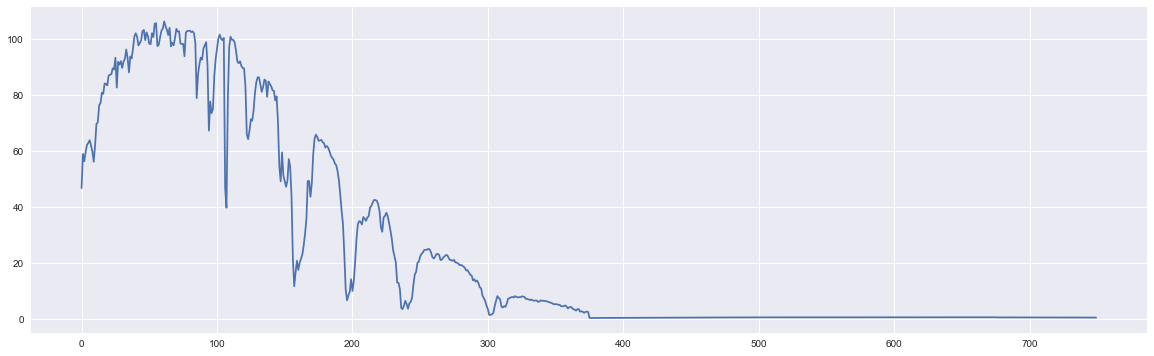

In [13]:
plt.figure(figsize=(20,6))
plt.plot(m)

In [14]:
m_a = m[0:nBandsY]
m_b = m[nBandsY:2*nBandsY]
Caa = C[0:nBandsY,0:nBandsY]
Cab = C[0:nBandsY,nBandsY:2*nBandsY]
Cba = C[nBandsY:2*nBandsY,0:nBandsY]
Cbb = C[nBandsY:2*nBandsY,nBandsY:2*nBandsY]
print(np.shape(m_a))
print(np.shape(m_b))
print(np.shape(Caa))
print(np.shape(Cab))
print(np.shape(Cba))
print(np.shape(Cbb))
CaaInv = np.linalg.inv(Caa)

(375,)
(375,)
(375, 375)
(375, 375)
(375, 375)
(375, 375)


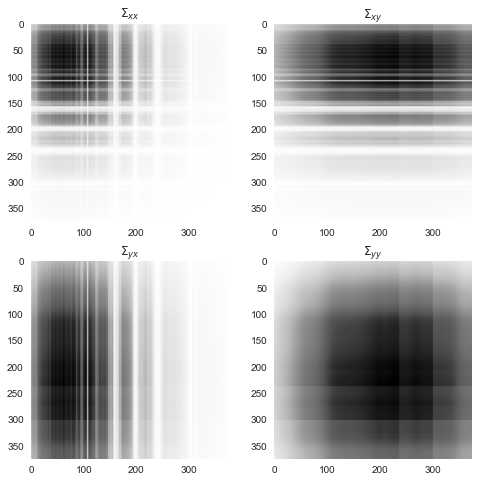

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(Caa, interpolation=None)
plt.grid(None)
plt.title('$\Sigma_{xx}$')
plt.subplot(222)
plt.imshow(Cab, interpolation=None)
plt.grid(None) 
plt.title('$\Sigma_{xy}$')
plt.subplot(223)
plt.imshow(Cba, interpolation=None)
plt.grid(None) 
plt.title('$\Sigma_{yx}$')
plt.subplot(224)
plt.imshow(Cbb, interpolation=None)
plt.grid(None) 
plt.title('$\Sigma_{yy}$')
plt.savefig('covariance.png', dpi=500, bbox_inches='tight', pad_inches=0.1);
plt.show()

In [16]:
def pred(xa,m_a,m_b,Cba,CaaInv):
  return m_b + np.matmul(np.matmul(Cba,CaaInv),xa-m_a)

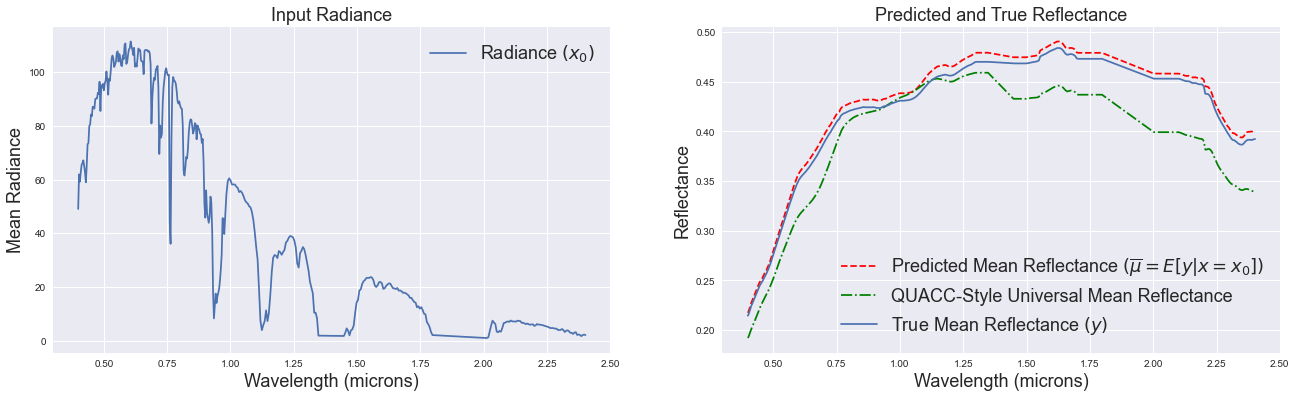

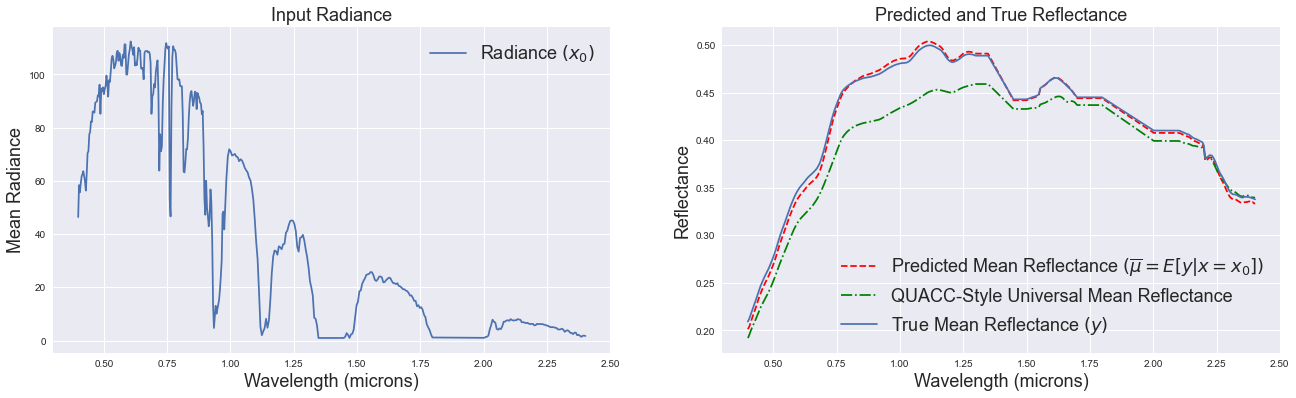

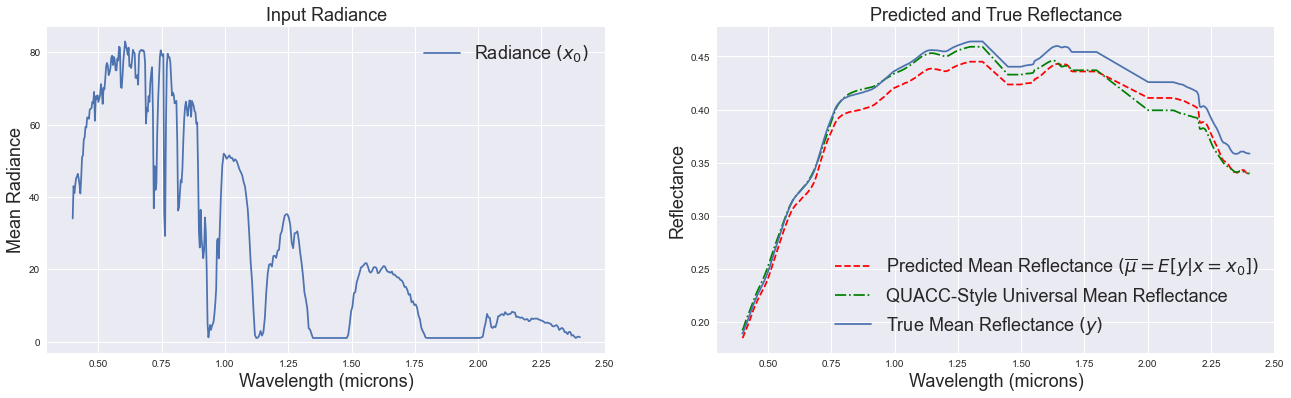

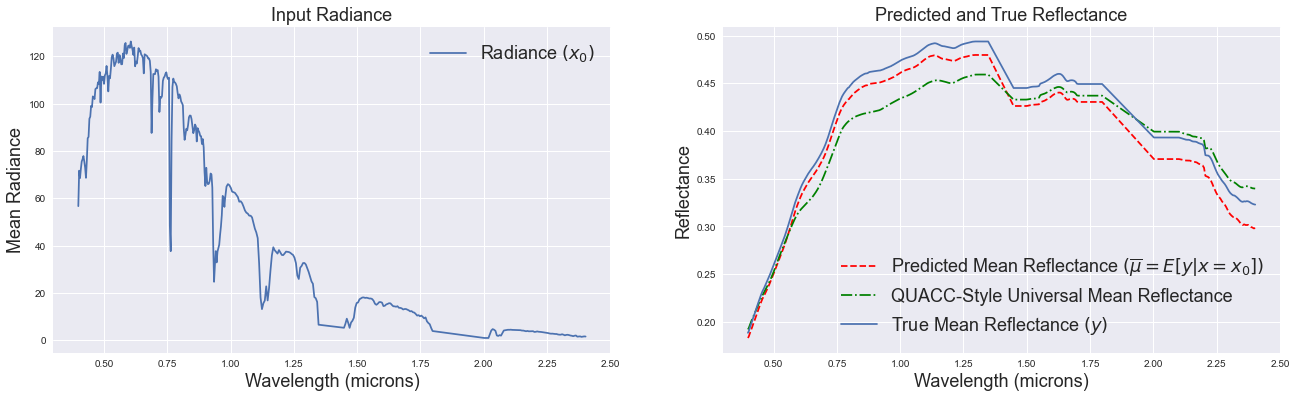

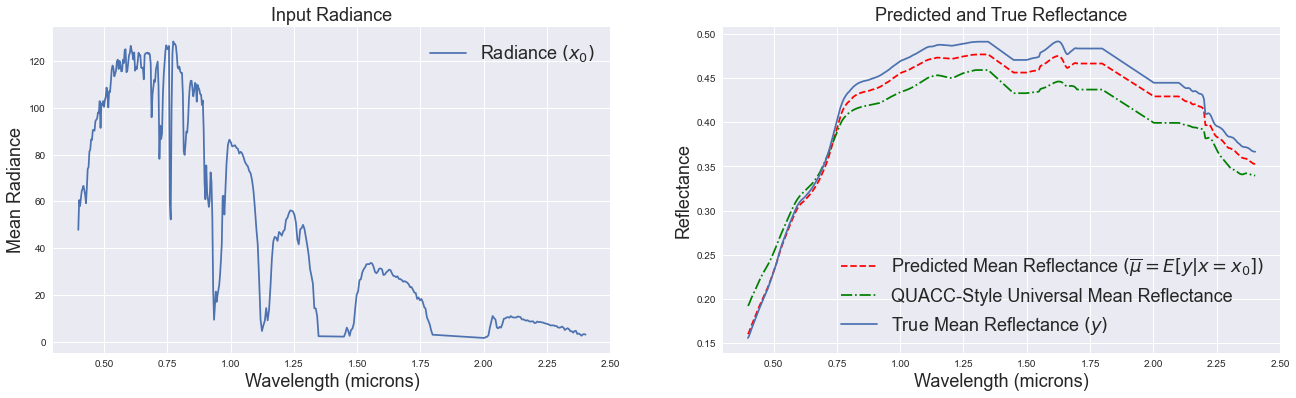

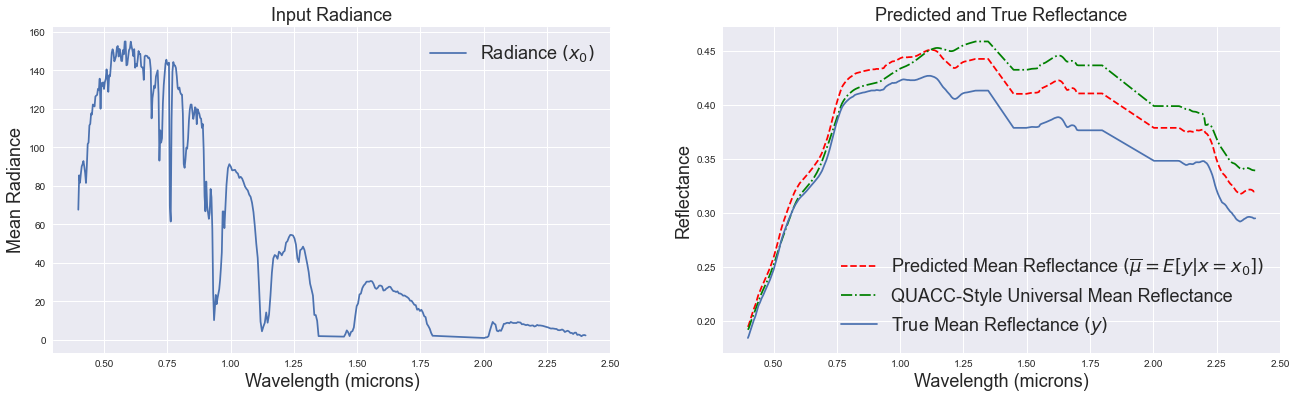

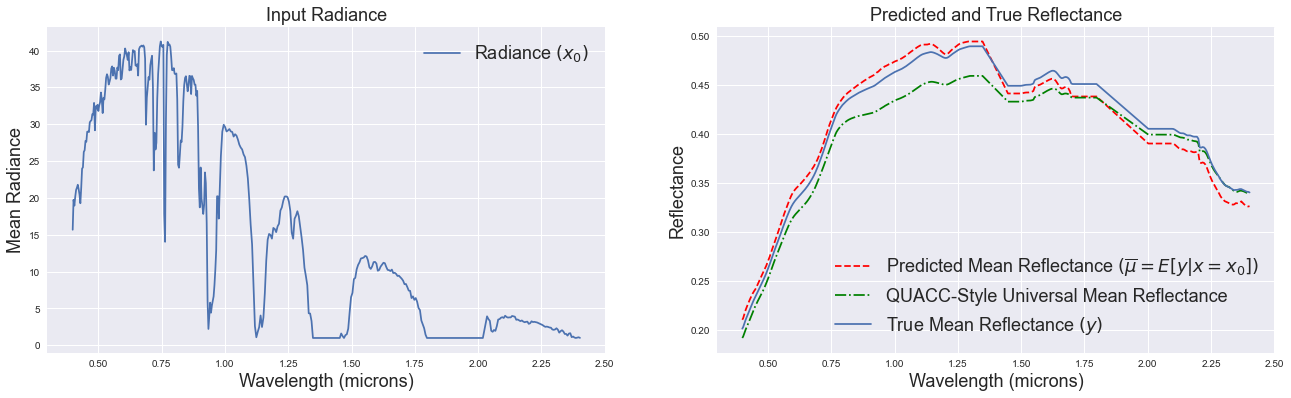

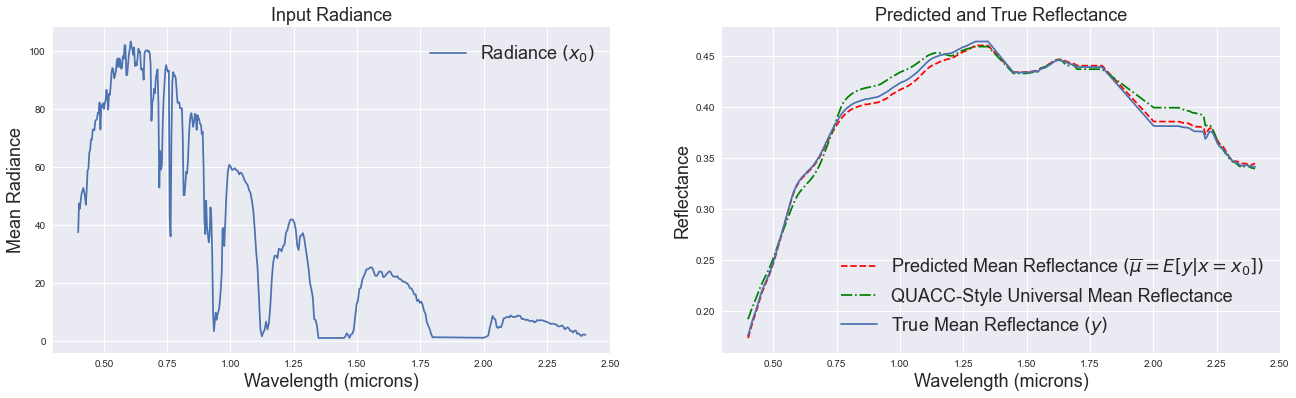

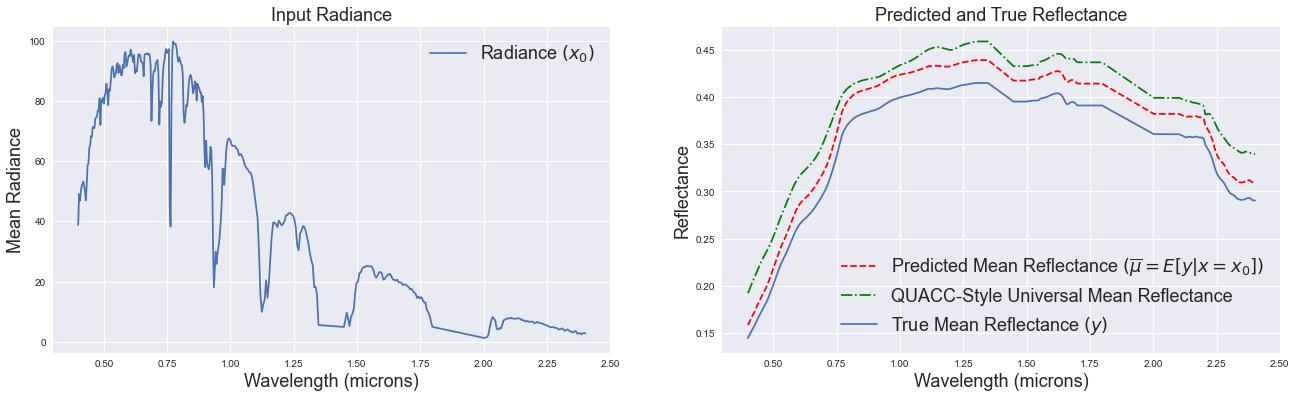

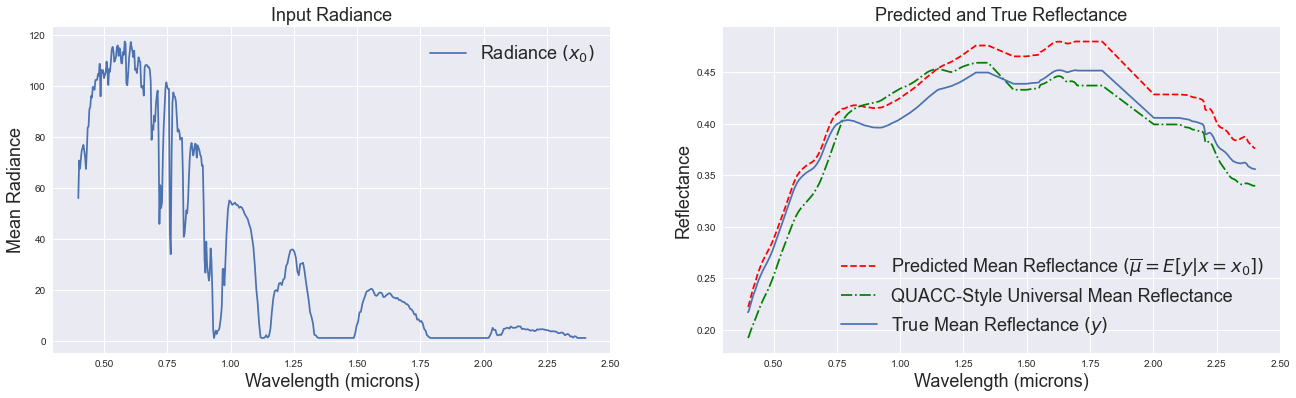

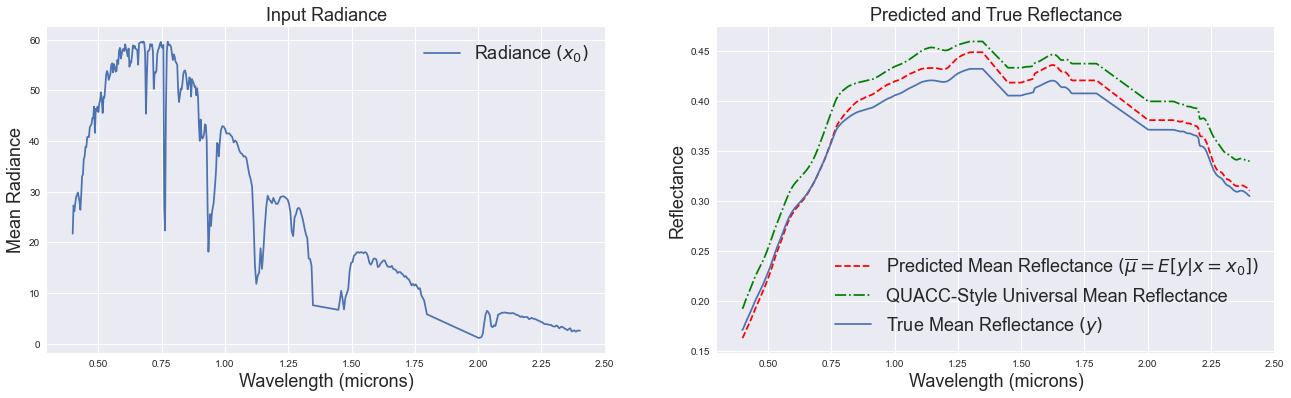

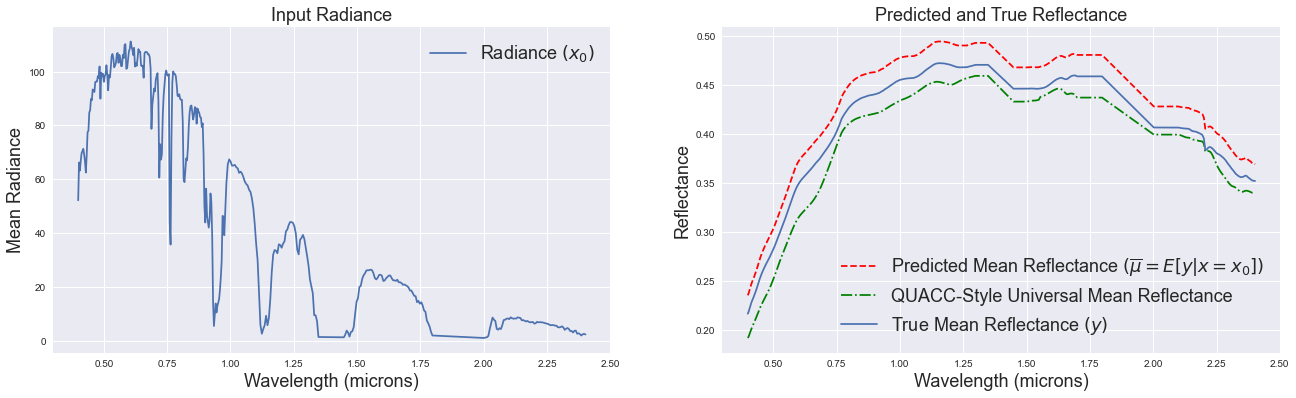

In [39]:
for idx in range(12):
  Y_pred = pred(X_test[idx,:],m_a,m_b,Cba,CaaInv)
  plt.figure(figsize=(22,6))
  plt.subplot(121)
  plt.plot(wl,X_test[idx,:], label='Radiance $(x_0)$')
  plt.title('Input Radiance', fontsize = 18)
  plt.xlabel('Wavelength (microns)', fontsize = 18)
  plt.ylabel('Mean Radiance', fontsize = 18)
  plt.legend(fontsize = 18)
  plt.subplot(122)
  plt.title('Predicted and True Reflectance', fontsize = 18)
  plt.plot(wl,Y_test[idx,:],'r--', label='Predicted Mean Reflectance $(\overline{\mu}=E[y|x=x_0])$')
  plt.plot(wl,m_b,'g', linestyle='dashdot', label='QUACC-Style Universal Mean Reflectance')
  plt.plot(wl,Y_pred, label='True Mean Reflectance $(y)$')
  plt.xlabel('Wavelength (microns)', fontsize = 18)
  plt.ylabel('Reflectance', fontsize = 18)
  plt.legend(fontsize = 18)
  plt.savefig('RadianceAndPRedictedReflectance_'+str(idx)+'.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

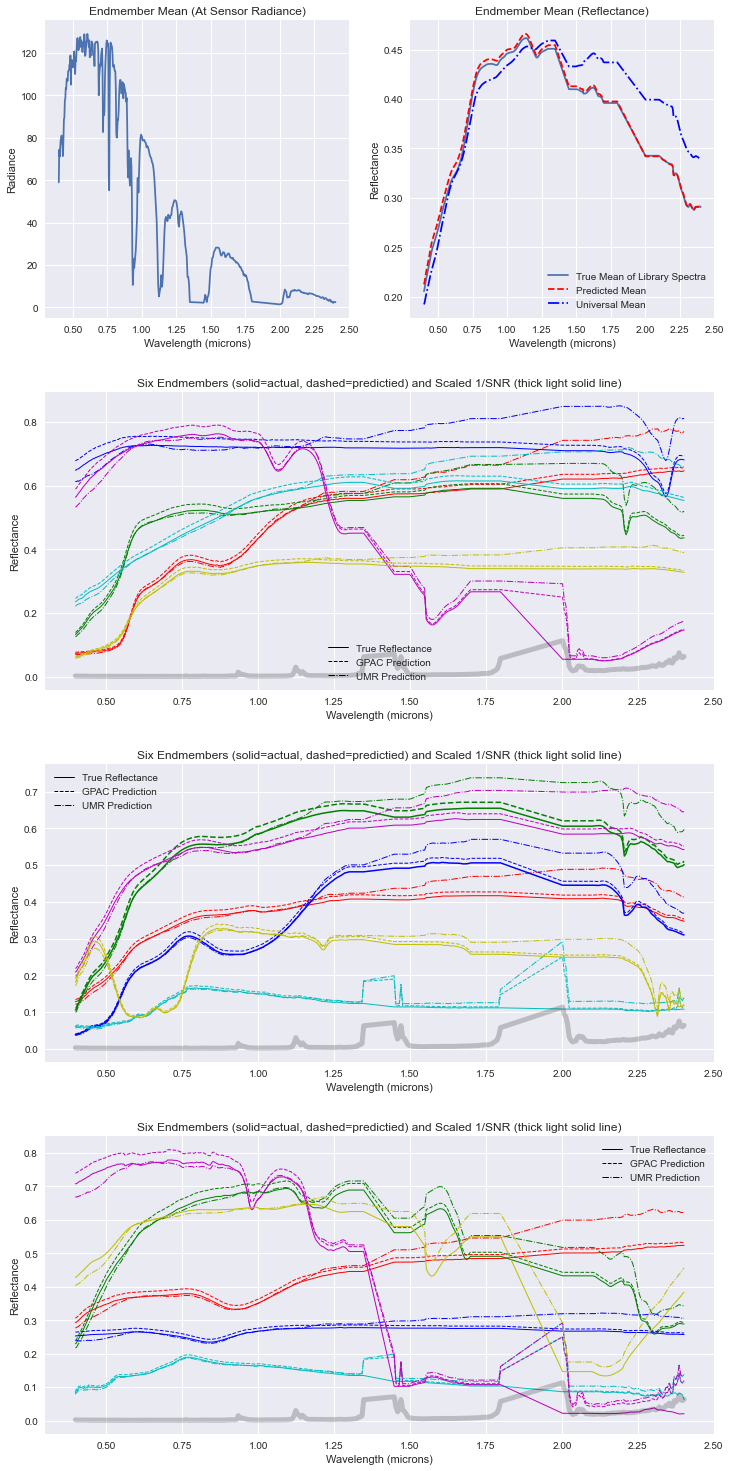

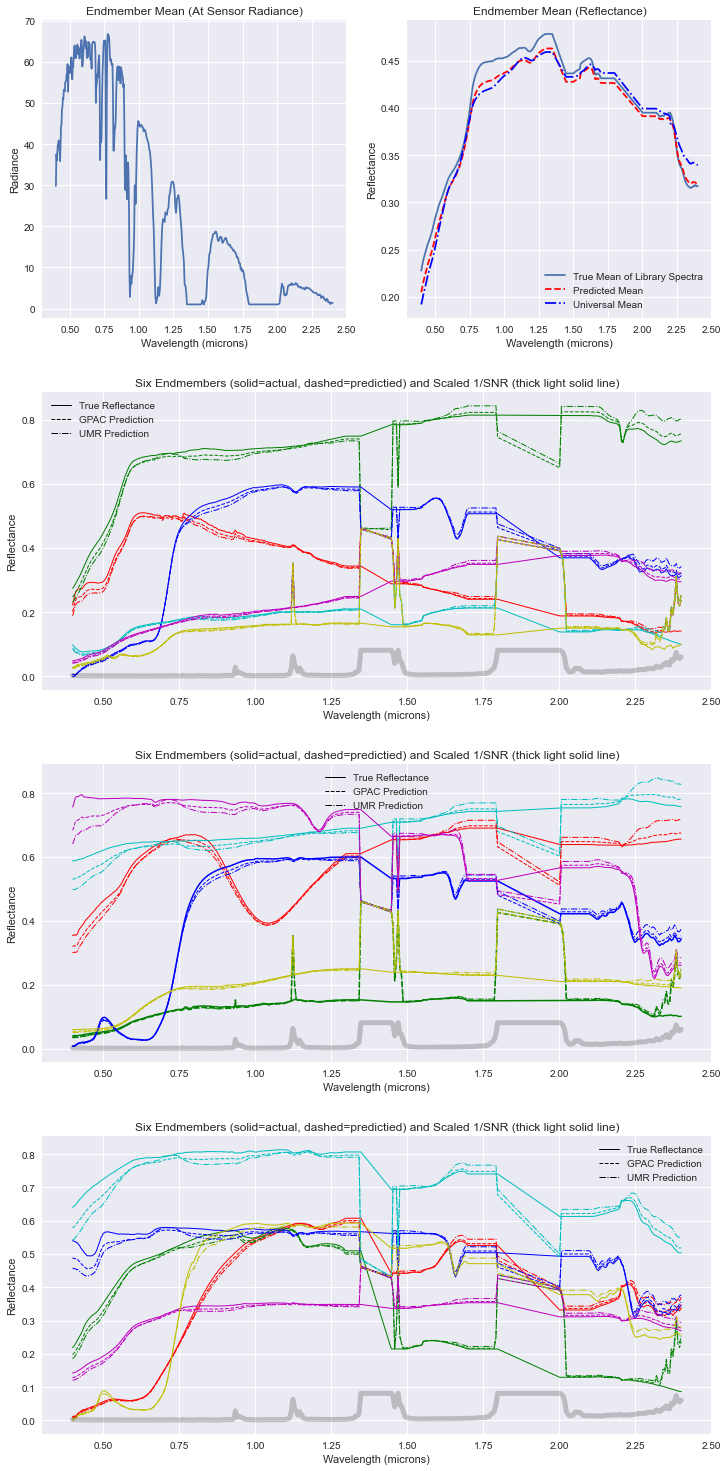

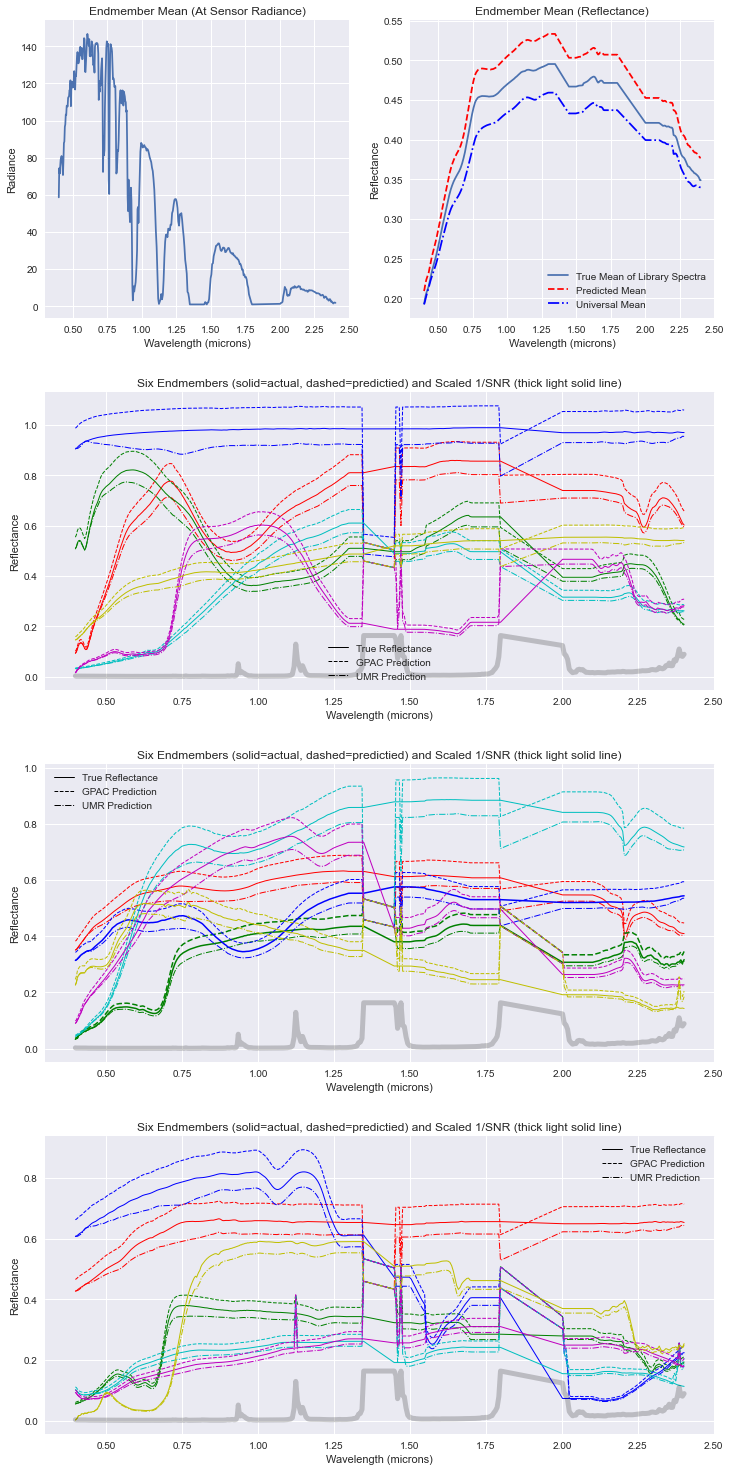

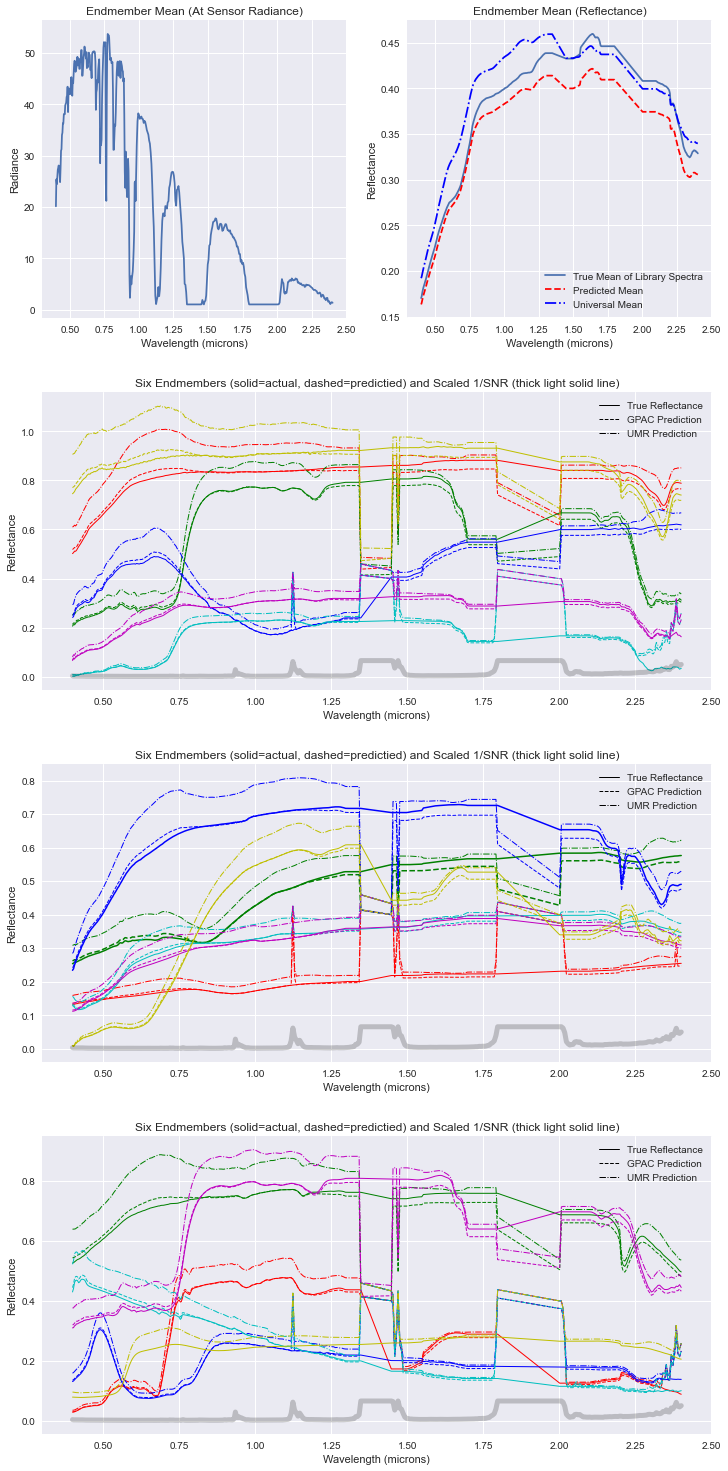

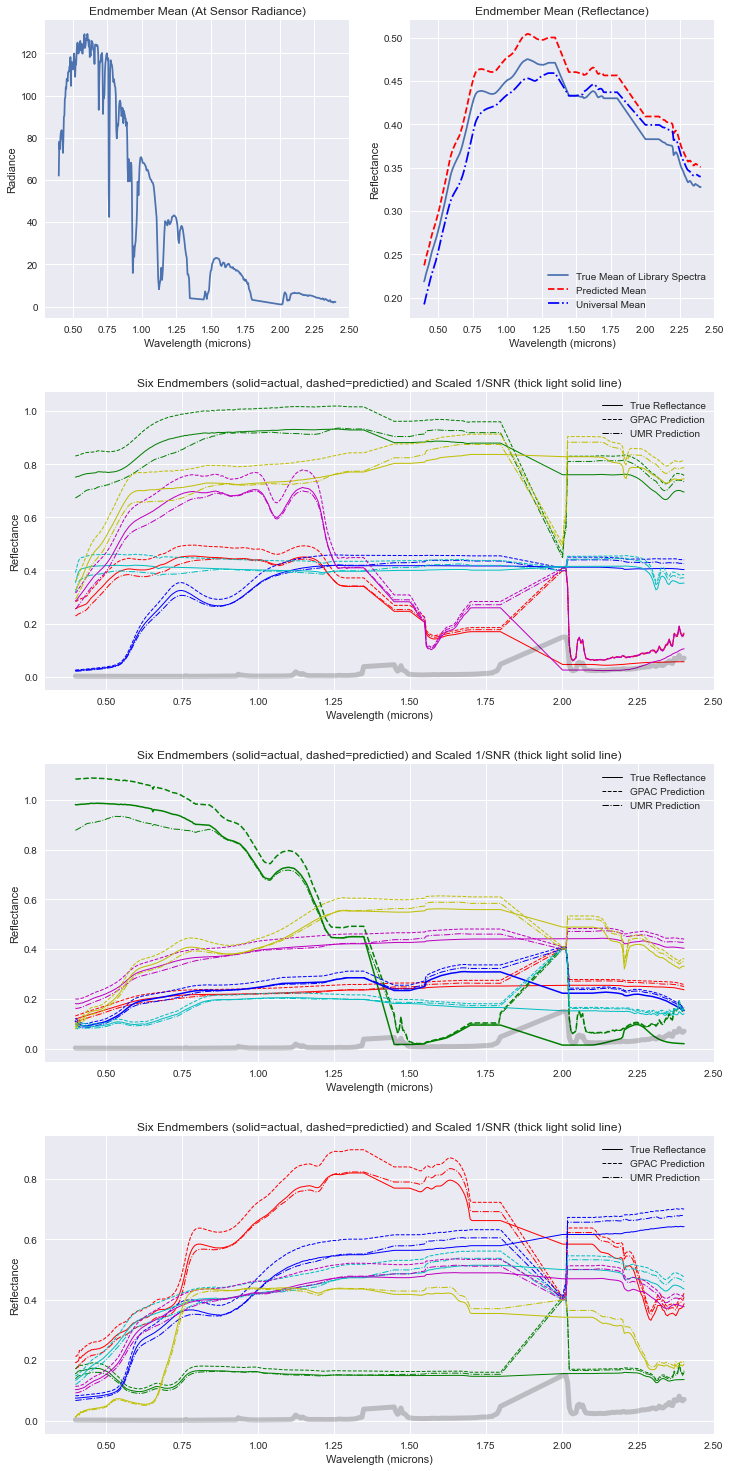

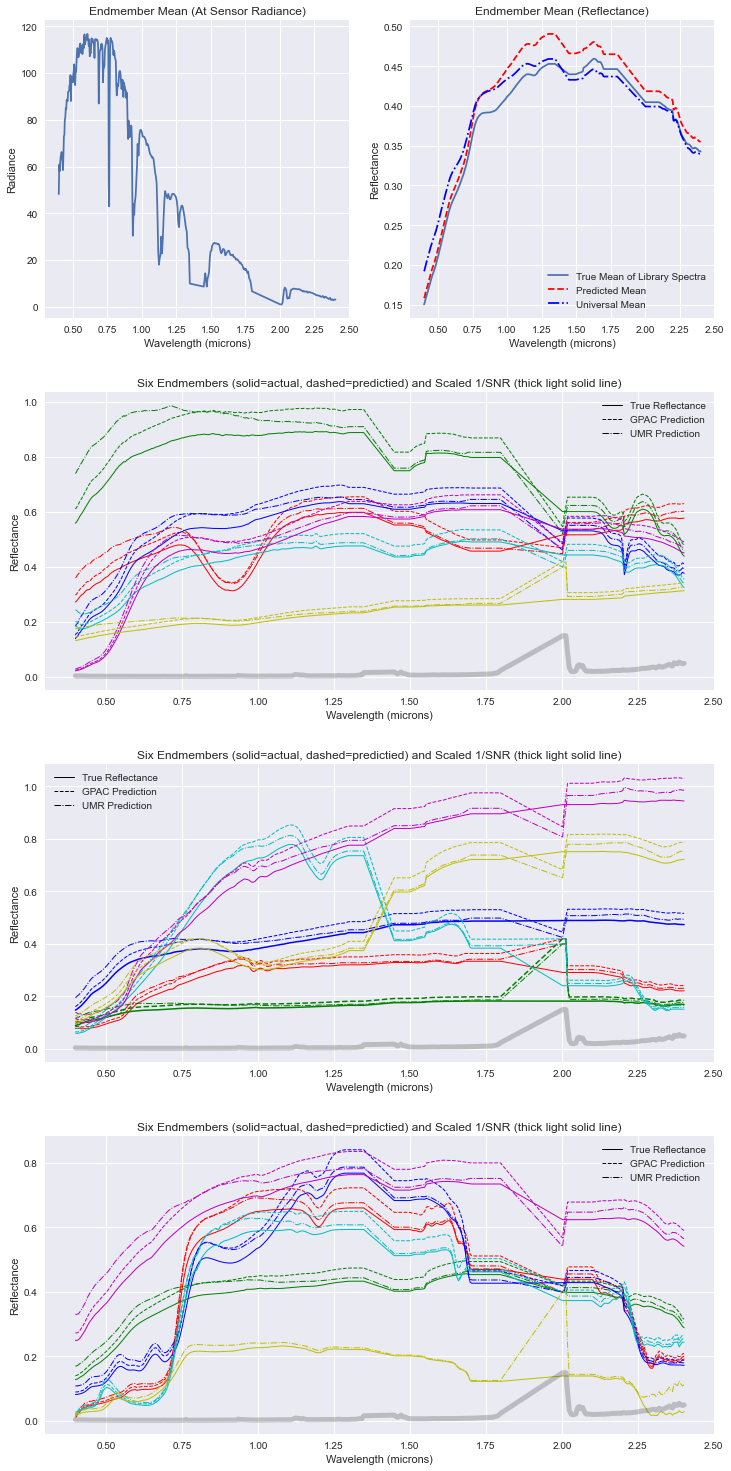

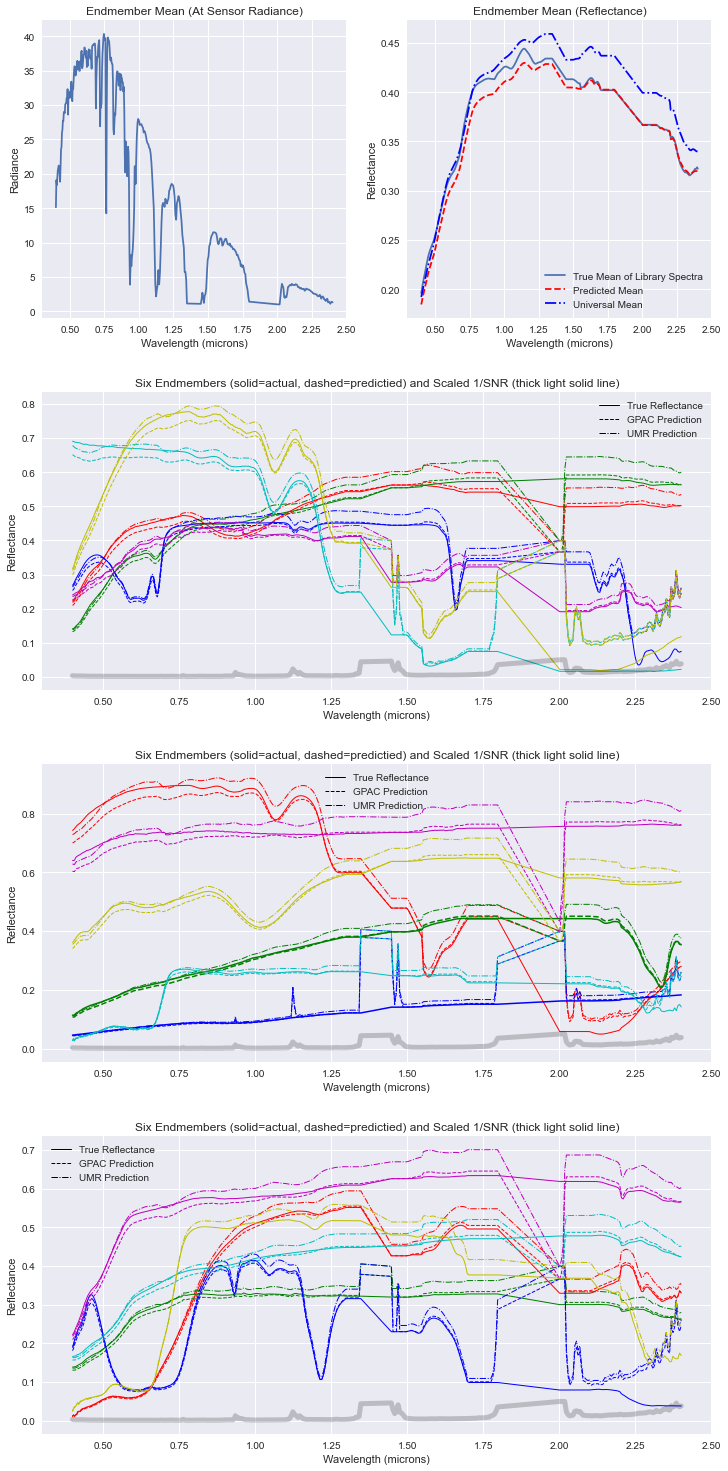

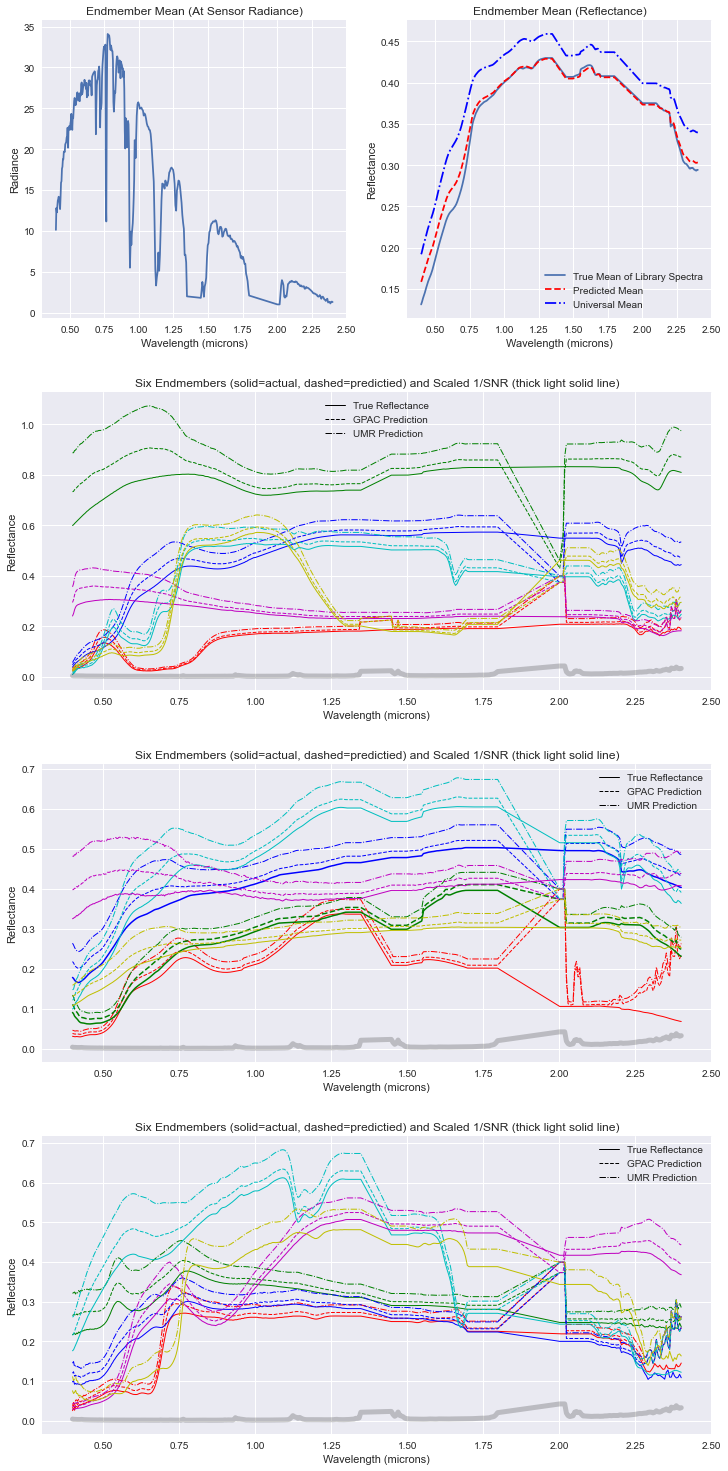

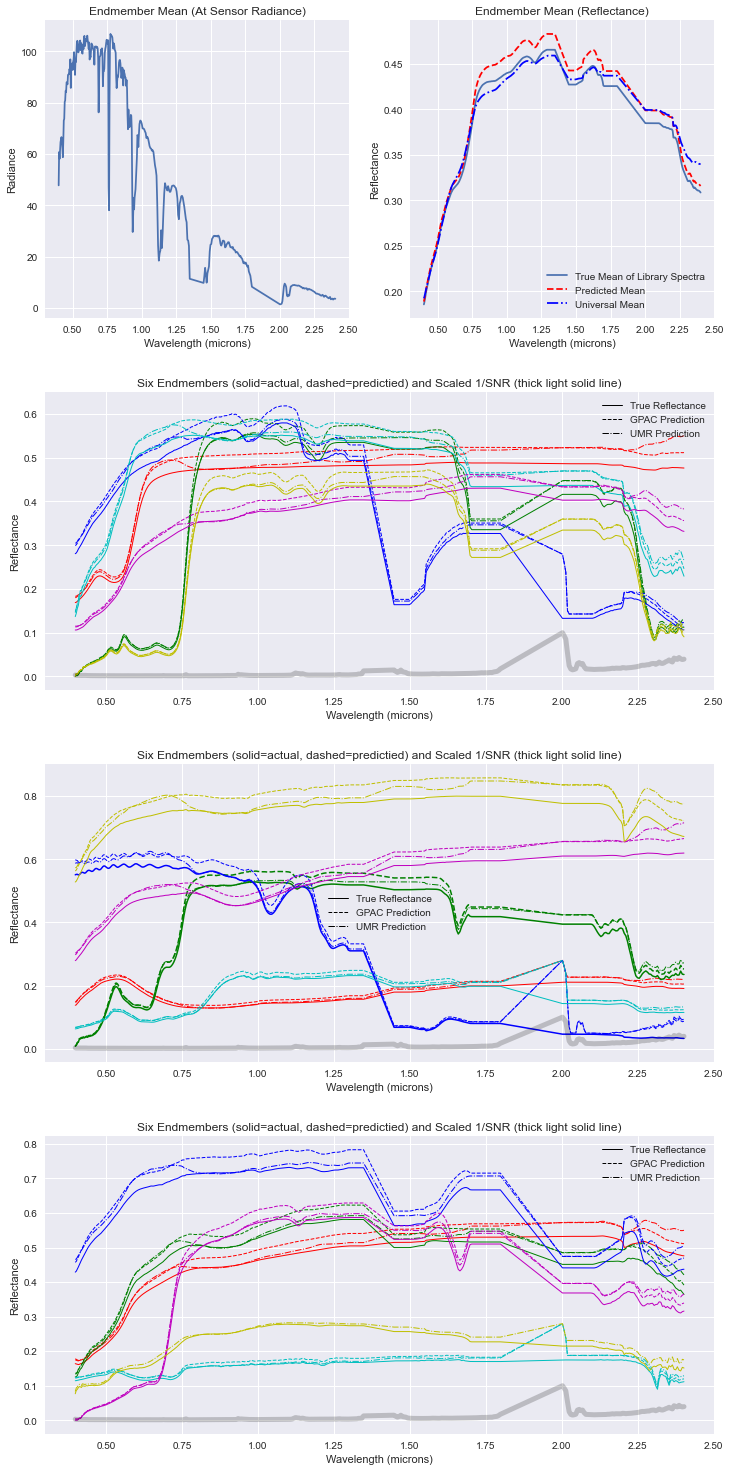

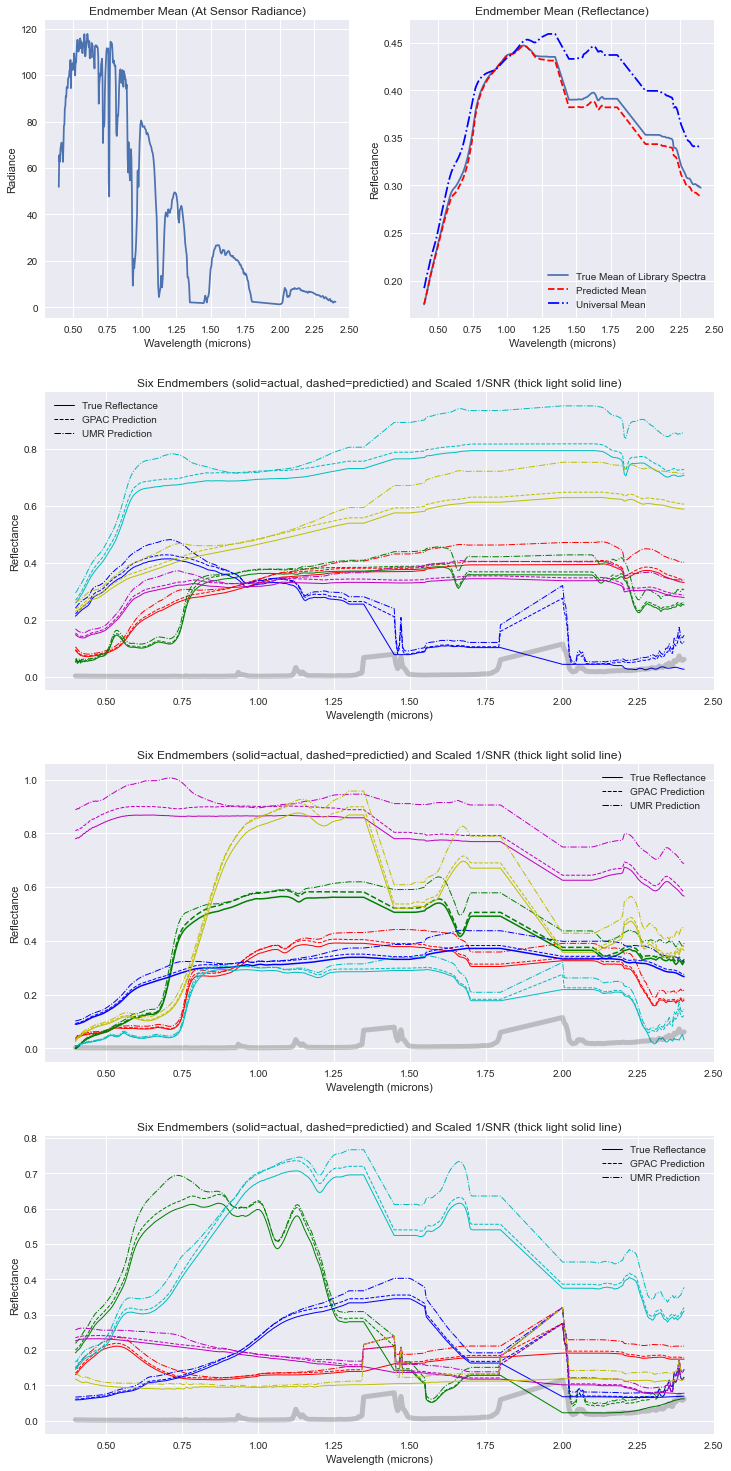

In [40]:
lw = 1
custom_lines = [Line2D([0], [0], color='k', lw=lw),
                Line2D([0], [0], color='k', lw=lw, linestyle='dashed'),
                Line2D([0], [0], color='k', lw=lw, linestyle='dashdot')]

for i in range(10):
  idx = np.random.randint(0,nTestObs)
  Y_pred = pred(X_test[idx,:],m_a,m_b,Cba,CaaInv)
  gain = Y_pred/X_test[idx,:]
  gainQ = m_b/X_test[idx,:]
  SNRi = np.mean(X_test[idx,:])/(X_test[idx,:]*len(wl))

  fig = plt.figure(figsize=(12,26))
  grid = GridSpec(4, 2, figure=fig)
  plt.subplots_adjust(hspace=0.25)
  ax1 = fig.add_subplot(grid[0,0])
  ax1.plot(wl,X_test[idx,:])
  ax1.set_xlabel("Wavelength (microns)")
  ax1.set_ylabel("Radiance")
  ax1.set_title("Endmember Mean (At Sensor Radiance)")
  ax2 = fig.add_subplot(grid[0,1])
  ax2.plot(wl,Y_test[idx,:], label='True Mean of Library Spectra')
  ax2.plot(wl,Y_pred, 'r--', label='Predicted Mean')
  ax2.plot(wl,m_b, 'b', label='Universal Mean', linestyle='dashdot')
  ax2.legend()
  ax2.set_xlabel("Wavelength (microns)")
  ax2.set_ylabel("Reflectance")
  ax2.set_title("Endmember Mean (Reflectance)")
  ax3 = fig.add_subplot(grid[1,0:2])
  ax3.plot(wl,Y_test_full[idx,2,:],'r', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,2,:]*gain,'r--', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,2,:]*gainQ,'r', linestyle='dashdot', linewidth=lw)
  ax3.plot(wl,Y_test_full[idx,3,:],'g', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,3,:]*gain,'g--', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,3,:]*gainQ,'g', linestyle='dashdot', linewidth=lw)
  ax3.plot(wl,Y_test_full[idx,4,:],'b', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,4,:]*gain,'b--', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,4,:]*gainQ,'b', linestyle='dashdot', linewidth=lw)
  ax3.plot(wl,Y_test_full[idx,5,:],'c', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,5,:]*gain,'c--', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,5,:]*gainQ,'c', linestyle='dashdot', linewidth=lw)
  ax3.plot(wl,Y_test_full[idx,6,:],'m', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,6,:]*gain,'m--', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,6,:]*gainQ,'m', linestyle='dashdot', linewidth=lw)
  ax3.plot(wl,Y_test_full[idx,7,:],'y', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,7,:]*gain,'y--', linewidth=lw)
  ax3.plot(wl,X_test_full[idx,7,:]*gainQ,'y', linestyle='dashdot', linewidth=lw)
  ax3.plot(wl,SNRi, 'k', linewidth=5, alpha=0.2)
  ax3.set_title("Six Endmembers (solid=actual, dashed=predictied) and Scaled 1/SNR (thick light solid line)")
  ax3.set_xlabel("Wavelength (microns)")
  ax3.set_ylabel("Reflectance")
  ax3.legend(custom_lines, ['True Reflectance', 'GPAC Prediction', 'UMR Prediction'])
  ax4 = fig.add_subplot(grid[2,0:2])
  ax4.plot(wl,Y_test_full[idx,8,:],'r', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,8,:]*gain,'r--', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,8,:]*gainQ,'r', linestyle='dashdot', linewidth=lw)
  ax4.plot(wl,Y_test_full[idx,9,:],'g', linewidth=1.5)
  ax4.plot(wl,X_test_full[idx,9,:]*gain,'g--', linewidth=1.5)
  ax4.plot(wl,X_test_full[idx,9,:]*gainQ,'g', linestyle='dashdot', linewidth=lw)
  ax4.plot(wl,Y_test_full[idx,10,:],'b', linewidth=1.5)
  ax4.plot(wl,X_test_full[idx,10,:]*gain,'b--', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,10,:]*gainQ,'b', linestyle='dashdot', linewidth=lw)
  ax4.plot(wl,Y_test_full[idx,11,:],'c', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,11,:]*gain,'c--', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,11,:]*gainQ,'c', linestyle='dashdot', linewidth=lw)
  ax4.plot(wl,Y_test_full[idx,12,:],'m', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,12,:]*gain,'m--', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,12,:]*gainQ,'m', linestyle='dashdot', linewidth=lw)
  ax4.plot(wl,Y_test_full[idx,13,:],'y', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,13,:]*gain,'y--', linewidth=lw)
  ax4.plot(wl,X_test_full[idx,13,:]*gainQ,'y', linestyle='dashdot', linewidth=lw);
  ax4.plot(wl,SNRi, 'k', linewidth=5, alpha=0.2)
  ax4.set_title("Six Endmembers (solid=actual, dashed=predictied) and Scaled 1/SNR (thick light solid line)")
  ax4.set_xlabel("Wavelength (microns)")
  ax4.set_ylabel("Reflectance")
  ax4.legend(custom_lines, ['True Reflectance', 'GPAC Prediction', 'UMR Prediction'])
  ax5 = fig.add_subplot(grid[3,0:2])
  ax5.plot(wl,Y_test_full[idx,14,:],'r', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,14,:]*gain,'r--', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,14,:]*gainQ,'r', linestyle='dashdot', linewidth=lw)
  ax5.plot(wl,Y_test_full[idx,15,:],'g', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,15,:]*gain,'g--', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,15,:]*gainQ,'g', linestyle='dashdot', linewidth=lw)
  ax5.plot(wl,Y_test_full[idx,16,:],'b', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,16,:]*gain,'b--', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,16,:]*gainQ,'b', linestyle='dashdot', linewidth=lw)
  ax5.plot(wl,Y_test_full[idx,17,:],'c', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,17,:]*gain,'c--', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,17,:]*gainQ,'c', linestyle='dashdot', linewidth=lw)
  ax5.plot(wl,Y_test_full[idx,18,:],'m', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,18,:]*gain,'m--', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,18,:]*gainQ,'m', linestyle='dashdot', linewidth=lw)
  ax5.plot(wl,Y_test_full[idx,19,:],'y', linewidth=lw)
  ax5.plot(wl,X_test_full[idx,19,:]*gainQ,'y', linestyle='dashdot', linewidth=lw);
  ax5.plot(wl,SNRi, 'k', linewidth=5, alpha=0.2)
  ax5.set_title("Six Endmembers (solid=actual, dashed=predictied) and Scaled 1/SNR (thick light solid line)")
  ax5.set_xlabel("Wavelength (microns)")
  ax5.set_ylabel("Reflectance")
  ax5.legend(custom_lines, ['True Reflectance', 'GPAC Prediction', 'UMR Prediction'])
  plt.savefig('predictionResults_'+str(idx)+'.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [19]:
CC = Caa - np.matmul(np.matmul(Cab, np.linalg.pinv(Cbb)), Cba)
eVals, eVecs = np.linalg.eig(CC)

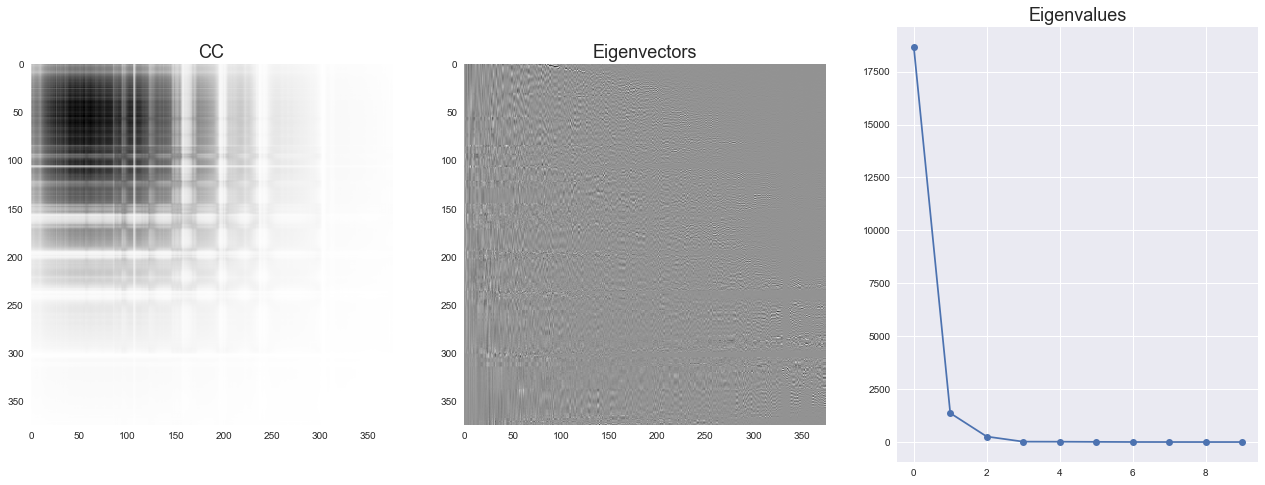

In [20]:
plt.figure(figsize=(22,8))
plt.subplot(131)
plt.imshow(CC)
plt.grid(None)
plt.title('CC', fontsize = 18)
plt.subplot(132)
plt.imshow(eVecs.real)
plt.grid(None)
plt.title('Eigenvectors', fontsize = 18)
plt.subplot(133)
plt.plot(eVals[0:10].real, 'o-')
plt.title('Eigenvalues', fontsize = 18);
plt.savefig('ConditionaCovariance.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

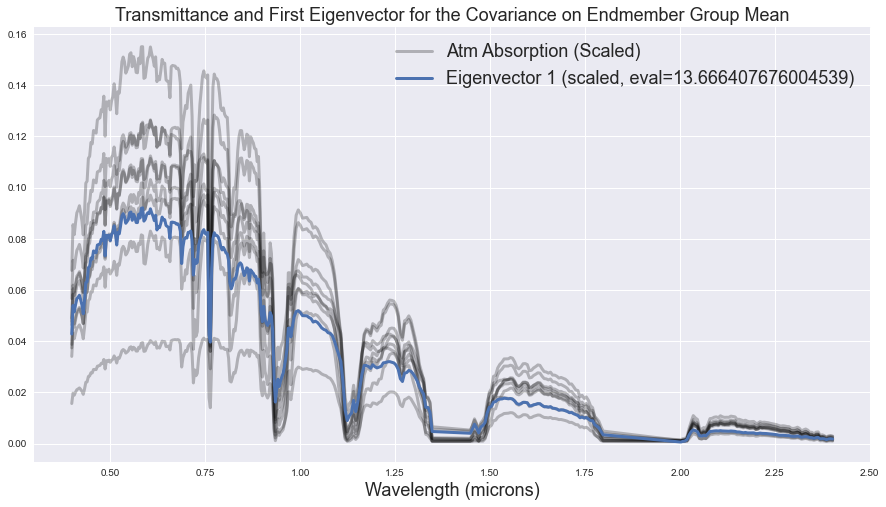

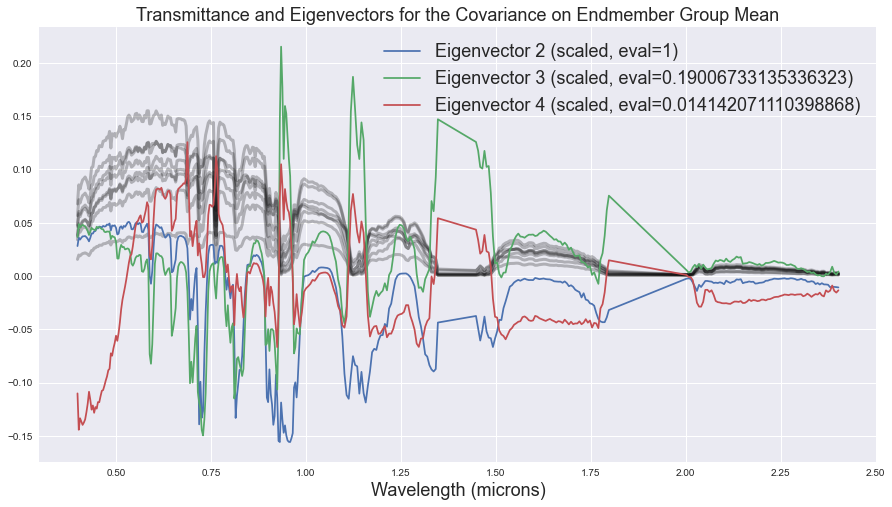

In [21]:
plt.figure(figsize=(15,8))
plt.plot(wl,0.001*X_test[0,:], 'k', linewidth = 3, alpha=0.25, label='Atm Absorption (Scaled)')
plt.plot(wl,0.001*X_test[1,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[2,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[3,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[4,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[5,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[6,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[7,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[8,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,(-1)*eVecs[:,0].real.flatten(), linewidth=3, label='Eigenvector 1 (scaled, eval='+str(eVals[0].real/eVals[1].real)+')')
plt.legend(fontsize = 18)
plt.xlabel("Wavelength (microns)", fontsize = 18);
plt.title("Transmittance and First Eigenvector for the Covariance on Endmember Group Mean", fontsize = 18)
plt.savefig('covarianceEigenVectors1.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

plt.figure(figsize=(15,8))
plt.plot(wl,0.001*X_test[1,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[2,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[3,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[4,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[5,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[6,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[7,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[8,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,eVecs[:,1].real.flatten(), label='Eigenvector 2 (scaled, eval='+str(1)+')')
plt.plot(wl,(-1)*eVecs[:,3].real.flatten(), label='Eigenvector 3 (scaled, eval='+str(eVals[2].real/eVals[1].real)+')')
plt.plot(wl,(-1)*eVecs[:,4].real.flatten(), label='Eigenvector 4 (scaled, eval='+str(eVals[3].real/eVals[1].real)+')')
plt.legend(fontsize = 18)
plt.xlabel("Wavelength (microns)", fontsize = 18);
plt.title("Transmittance and Eigenvectors for the Covariance on Endmember Group Mean", fontsize = 18)
plt.savefig('covarianceEigenVectors2.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [22]:
N = nTestObs*0+2000
CPAC_check = np.zeros(N*39)
QUAC_check = np.zeros(N*39)
CPAC_Corr = np.zeros(N*39)
QUAC_Corr = np.zeros(N*39)
CPAC_softcheck = np.zeros(N*39)
QUAC_softcheck = np.zeros(N*39)
for obs_idx in range(N):
  Y_pred = pred(X_test[obs_idx,:],m_a,m_b,Cba,CaaInv)
  gain = Y_pred/X_test[obs_idx,:]

  Y_pred_Q = m_b
  gain_Q = Y_pred_Q/X_test[obs_idx,:]
  for em_idx in range(39):
    idx = obs_idx*39+em_idx
    Y_True = Y_test_full[obs_idx,em_idx,:]
    Y_Cpred = X_test_full[obs_idx,em_idx,:]*gain
    Y_Qpred = X_test_full[obs_idx,em_idx,:]*gain_Q

    CPAC_Corr[idx] = np.corrcoef(Y_True,Y_Cpred)[0,1]
    QUAC_Corr[idx] = np.corrcoef(Y_True,Y_Qpred)[0,1]

    CPAC_check[idx] = ((0.85*Y_True<Y_Cpred).all() and (1.15*Y_True>Y_Cpred).all())
    QUAC_check[idx] = ((0.85*Y_True<Y_Qpred).all() and (1.15*Y_True>Y_Qpred).all())

    CPAC_softcheck[idx] = np.sum((0.85*Y_True<Y_Cpred) * (1.15*Y_True>Y_Cpred)) > 0.98*375
    QUAC_softcheck[idx] = np.sum((0.85*Y_True<Y_Qpred) * (1.15*Y_True>Y_Qpred)) > 0.98*375
  
  if (obs_idx%500==0):
    print(str(obs_idx)+' of '+str(nTestObs)+' completed.')
  

0 of 33000 completed.
500 of 33000 completed.
1000 of 33000 completed.
1500 of 33000 completed.


In [23]:
print(np.sum(CPAC_Corr)/len(CPAC_Corr))
print(np.sum(QUAC_Corr)/len(CPAC_Corr))

print(np.sum(CPAC_check)/len(CPAC_Corr))
print(np.sum(QUAC_check)/len(CPAC_Corr))

print(np.sum(CPAC_softcheck)/len(CPAC_Corr))
print(np.sum(QUAC_softcheck)/len(CPAC_Corr))

0.9582808510513258
0.9366916549761138
0.4282948717948718
0.2298076923076923
0.7314487179487179
0.4077051282051282


In [24]:
print(np.mean(CPAC_Corr))
print(np.std(CPAC_Corr))
print(np.mean(QUAC_Corr))
print(np.std(QUAC_Corr))

0.9582808510513258
0.11112168636448347
0.9366916549761138
0.1380032596207296


In [ ]:
0.9579865705737679
0.11220348810955307
0.9342199295987359
0.14387781731543262

0.14387781731543262

## Autoencoder

In [ ]:
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D, Conv1D
from keras.models import Model
import copy

In [ ]:
# reduce number of bands to get even numbers for the autoencoder
nBands = 372
Xdata =  Xdata[:,:,0:nBands]
Ydata =  Ydata[:,:,0:nBands]
wl = wl[0:nBands]

In [ ]:
# Define the Auto Encoder

# Encoder
inputs = Input(shape=(nSpec,372,1))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.005)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
x = Dropout(0.005)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 372, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 372, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 186, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 186, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 186, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 93, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 93, 32)        9248  

In [ ]:
# lets chape the shape of each of these:
print('Xdata shape: '+str(Xdata.shape))
print('Ydata shape: '+str(Ydata.shape))
print('wl shape: '+str(wl.shape))
print('Number of observations: '+str(nObs))
print('Number of Spectra: '+str(nSpec))
print('Number bands in each spectrum: '+str(nBands))

Xdata shape: (100000, 40, 372)
Ydata shape: (100000, 40, 372)
wl shape: (372,)
Number of observations: 100000
Number of Spectra: 40
Number bands in each spectrum: 372


In [ ]:
# data for validation
X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata, test_size=0.33, random_state=42)

# scaling input data (I am not sure why we do this - just following other autoencoder demos)
X_train_a = X_train.reshape([-1,nSpec,nBands,1])
X_test_a = X_test.reshape([-1,nSpec,nBands,1])
Y_train_a = Y_train.reshape([-1,nSpec,nBands,1])
Y_test_a = Y_test.reshape([-1,nSpec,nBands,1])

In [ ]:
# Training
epochs = 59
batch_size = 256
history = autoencoder.fit(X_train_a,
                Y_train_a,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test_a, Y_test_a)
               )

Epoch 1/59
262/262 [==============================] - 1163s 4s/step - loss: 0.8820 - val_loss: 0.6158
Epoch 2/59
262/262 [==============================] - 1136s 4s/step - loss: 0.6113 - val_loss: 0.5973
Epoch 3/59
262/262 [==============================] - 1109s 4s/step - loss: 0.5970 - val_loss: 0.5898
Epoch 4/59
262/262 [==============================] - 1052s 4s/step - loss: 0.5908 - val_loss: 0.5848
Epoch 5/59
262/262 [==============================] - 1015s 4s/step - loss: 0.5877 - val_loss: 0.5825
Epoch 6/59
262/262 [==============================] - 955s 4s/step - loss: 0.5856 - val_loss: 0.5823
Epoch 7/59
262/262 [==============================] - 953s 4s/step - loss: 0.5843 - val_loss: 0.5842
Epoch 8/59
262/262 [==============================] - 1011s 4s/step - loss: 0.5830 - val_loss: 0.5844
Epoch 9/59
262/262 [==============================] - 1030s 4s/step - loss: 0.5824 - val_loss: 0.5808
Epoch 10/59
262/262 [==============================] - 1039s 4s/step - loss: 0.5822 

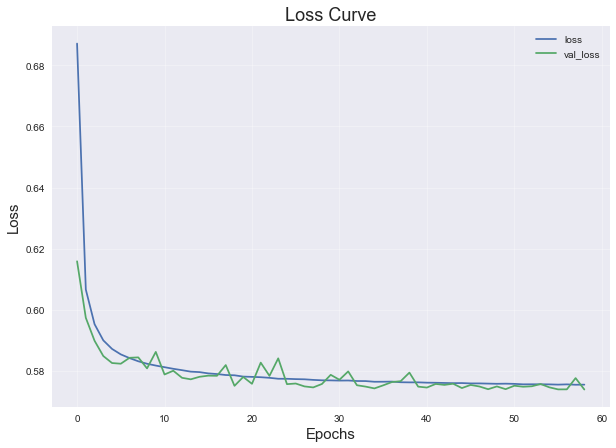

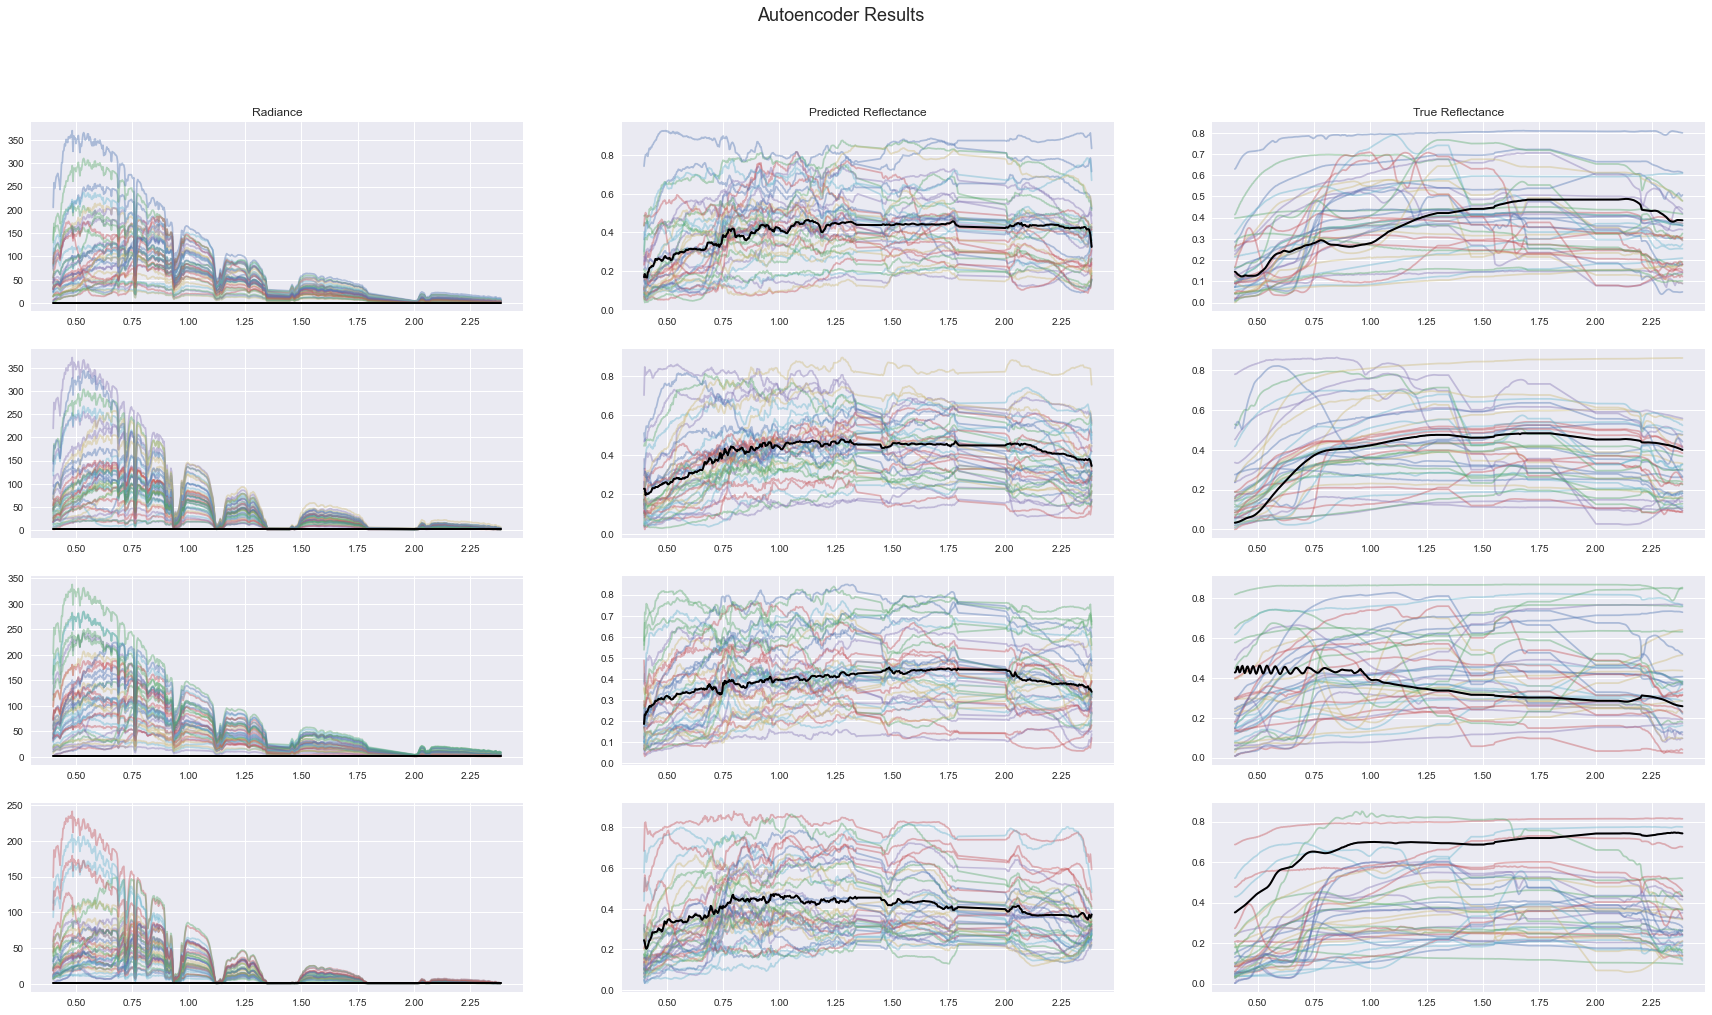

In [ ]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set
plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve.png")
plt.show()


# Select few random test images
num_imgs = 4
rand = np.random.randint(1, 100)
test_X = X_test_a[rand:rand+num_imgs] # slicing
test_Y = Y_test_a[rand:rand+num_imgs]
test_X_reflectance = autoencoder.predict(test_X) # predict

# Visualize test images with their denoised images
rows = 4  # defining no. of rows in figure
cols = 3  # defining no. of colums in figure
f = plt.figure(figsize=(10 * cols, 2 * rows * 2))  # defining a figure
for i in range(rows):
    f.add_subplot(4,3,i*cols+1)  # adding sub plot to figure on each iteration
    #plt.imshow(test_images[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Radiance')

    f.add_subplot(4,3,i*cols+2)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X_reflectance[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X_reflectance[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Predicted Reflectance')

    f.add_subplot(4,3,i*cols+3)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_Y[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_Y[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('True Reflectance')

f.suptitle("Autoencoder Results", fontsize=18)
plt.savefig("test_results.png")

plt.show()

In [ ]:
N = nTestObs*0+2000
A_Corr = np.zeros(N*39)
A_check = np.zeros(N*39)
A_softcheck = np.zeros(N*39)
for obs_idx in range(N):
    
  test_X = X_test_a[obs_idx,:,:,:] # slicing
  #print(np.shape(test_X))
  
  test_X = X_test_a[obs_idx:obs_idx+1]
  test_X_reflectance_a = autoencoder.predict(test_X) # predict

  for em_idx in range(39):
    idx = obs_idx*39+em_idx
    #print(np.shape(Y_test_full))
    #print(np.shape(test_X_reflectance_a))
    Y_True = Y_test_full[obs_idx,em_idx,0:nBands]
    Y_Apred = test_X_reflectance_a[:,em_idx,:].flatten()
    
    A_Corr[idx] = np.corrcoef(Y_True,Y_Apred)[0,1]
    A_check[idx] = ((0.85*Y_True<Y_Apred).all() and (1.15*Y_True>Y_Apred).all())
    A_softcheck[idx] = np.sum((0.85*Y_True<Y_Apred) * (1.15*Y_True>Y_Apred)) > 0.98*375
  
  if (obs_idx%500==0):
    print(str(obs_idx)+' of '+str(nTestObs)+' completed.')

0 of 33000 completed.
500 of 33000 completed.
1000 of 33000 completed.
1500 of 33000 completed.


In [ ]:
print(np.sum(A_Corr)/len(A_Corr))
print(np.sum(A_check)/len(A_Corr))
print(np.sum(A_softcheck)/len(A_Corr))

0.8635085066398085
0.0028846153846153848
0.014269230769230768


In [1]:
print(np.mean(A_Corr))
print(np.std(A_Corr))

NameError: name 'np' is not defined